In [3]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm





# beta_rel = 0.305
beta_rel = 0.106

# gamma = 1.050
gamma = 1.006


I=0.4
L = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 0.01 # <E> [eV] = kb*T
T_l =  0.001 # <E> [eV]
B = 0.060 # T for LEIR
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



length = 182.43280000000 #m
T = length/(c*beta_rel)
ms_per_turn = 1000*T





beta_x=10 
beta_y=4
emittance=10*1e-6

arc=dtk.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=0,disp_x_1=0,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )




num_particles=10000



In [12]:
#x=np.random.normal(0,np.sqrt(5*emittance) ,num_particles),
#px=np.random.normal(0, np.sqrt(emittance/5), num_particles),
#x=np.linspace(1*1e-3, 20*1e-3, num_particles),
#px=np.random.uniform(0, 0, num_particles),

dtk_particle = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=np.random.normal(0,np.sqrt(beta_x*emittance) ,num_particles),
        px=np.random.normal(0, np.sqrt(emittance/beta_x), num_particles),
        y=0,
        py=0,
        delta=0,
        zeta=0)

dtk_particle_copy_old=dtk_particle.copy()


dtk_cooler = dtk.elements.ElectronCooler(I=I,L=L,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         B=B,Z=Z,B_ratio=1e-10,
                                         Neutralisation_space_charge=1)

       

num_turns=int(0.5*10000)
num_turns=int(1)
# num_turns=int(100000)

x=[]
px=[]
action = []
force = []



for i in tqdm(range(num_turns)):
    x.append(dtk_particle.x)
    px.append(dtk_particle.px)
            
    #arc.track(dtk_particle)
        
    force.append(dtk_cooler.force(dtk_particle))
    #dtk_cooler.track(dtk_particle)


x = np.array(x)
px = np.array(px)
action = np.array(action)
force = np.array(force)


100%|██████████| 1/1 [00:00<00:00, 263.68it/s]


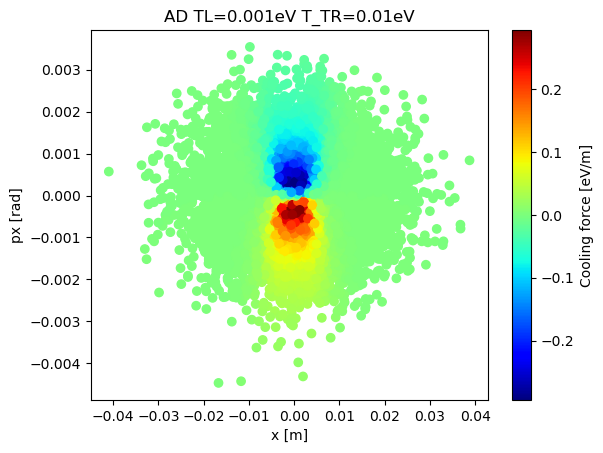

In [13]:
#plot force magnitude in phase space

plt.figure()
plt.scatter(x,px,c=force,cmap='jet')
plt.xlabel('x [m]')
plt.ylabel('px [rad]')
plt.title(f'AD TL={T_l}eV T_TR={T_perp}eV')
plt.colorbar().set_label("Cooling force [eV/m]")
plt.show()


force heat map in y-direction

In [6]:
dtk_particle_y = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=0.000000000001,
        px=0,
        y=np.random.normal(0,np.sqrt(beta_x*emittance) ,num_particles),
        py=np.random.normal(0, np.sqrt(emittance/beta_x), num_particles),
        delta=0,
        zeta=0)

dtk_particle_copy_old=dtk_particle.copy()



y=[]
py=[]
action = []
force = []



for i in tqdm(range(num_turns)):
    y.append(dtk_particle_y.y)
    py.append(dtk_particle_y.py)
    
    #arc.track(dtk_particle)
      
    force.append(dtk_cooler.force_y(dtk_particle_y))
    #dtk_cooler.track(dtk_particle)


y = np.array(y)
py = np.array(py)
action = np.array(action)
force = np.array(force)


100%|██████████| 1/1 [00:00<00:00, 367.50it/s]


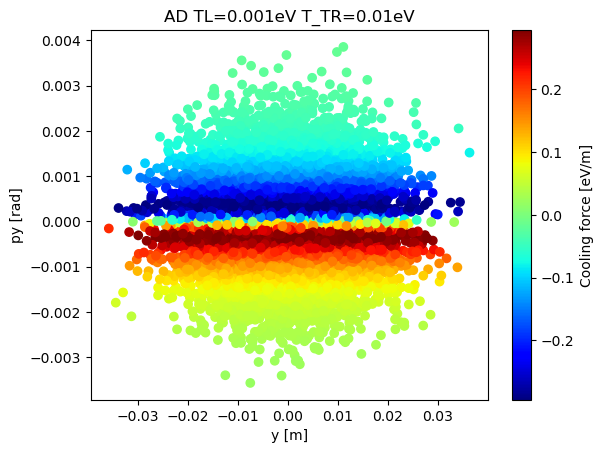

In [7]:
#plot force magnitude in phase space

plt.figure()
plt.scatter(y,py,c=force,cmap='jet')
plt.xlabel('y [m]')
plt.ylabel('py [rad]')
plt.title(f'AD TL={T_l}eV T_TR={T_perp}eV')
plt.colorbar().set_label("Cooling force [eV/m]")
plt.show()


force in longitudinal direction

In [10]:
num_particles=10000

#x=np.random.normal(0,np.sqrt(5*emittance) ,num_particles),
#px=np.random.normal(0, np.sqrt(emittance/5), num_particles),
#x=np.linspace(1*1e-3, 20*1e-3, num_particles),
#px=np.random.uniform(0, 0, num_particles),

dtk_particle_z = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=0.000000000001,
        px=0,
        y=0,
        py=0,
        delta=np.random.normal(0,5*1e-4 ,num_particles),
        zeta=np.random.normal(0,5*1e-4 ,num_particles))

dtk_particle_copy_old=dtk_particle.copy()


dtk_cooler = dtk.elements.ElectronCooler(I=I,L=L,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         B=B,Z=Z,B_ratio=0,
                                         Neutralisation_space_charge=1)

       

num_turns=int(0.5*10000)
num_turns=int(1)
# num_turns=int(100000)

z=[]
delta=[]
action = []
force = []



for i in tqdm(range(num_turns)):
    z.append(dtk_particle_z.zeta)
    delta.append(dtk_particle_z.delta)
            
    #arc.track(dtk_particle)
      
    force.append(dtk_cooler.force_l(dtk_particle_z))
    #dtk_cooler.track(dtk_particle)


z = np.array(z)
delta = np.array(delta)
action = np.array(action)
force = np.array(force)


100%|██████████| 1/1 [00:00<00:00, 275.90it/s]


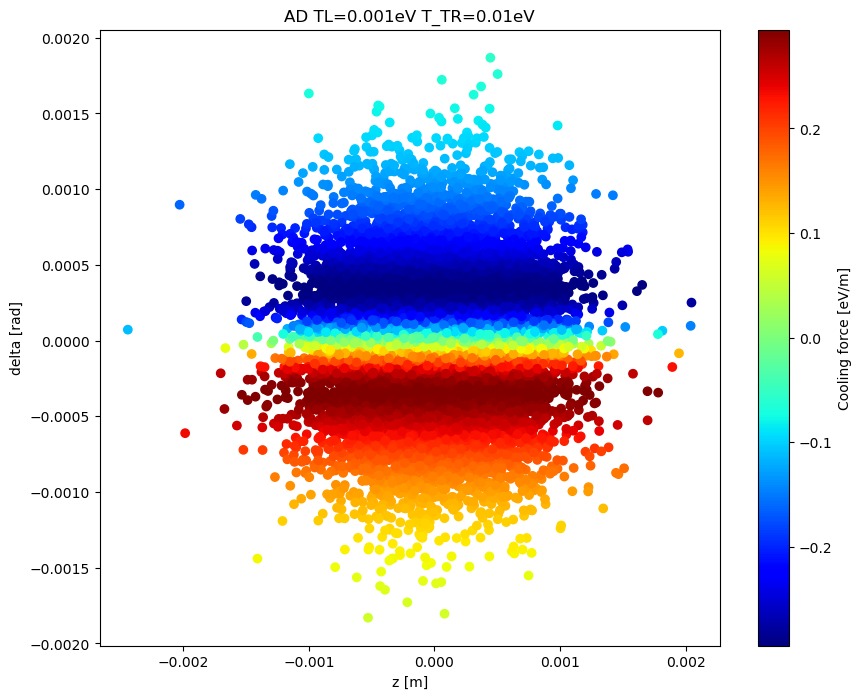

In [11]:
#plot force magnitude in phase space

plt.figure(figsize=(10, 8))
plt.scatter(z,delta,c=force,cmap='jet')
plt.xlabel('z [m]')
plt.ylabel('delta [rad]')
plt.title(f'AD TL={T_l}eV T_TR={T_perp}eV')
plt.colorbar().set_label("Cooling force [eV/m]")
plt.show()